## TODO
1. Проверить sound banks не на линухе, м.б. экспортнуть сразу в гитарпро на винде, т.к. на линухе все играет стандартное пианино.
2. Если экспортировать в drum не получится - перевести все ноты в набор основных звуков: кик, снейр, хэт, крэш и т.д., то, что есть в music21
3. Val loss всегда растет независимо от архитектуры. М.б. стоит избавиться от пауз, которые составляют 40 % партий и добавить конкатенацию с массивом длительностей
4. Или просто добавить больше партий?

In [1]:
import guitarpro
from music21 import instrument, note, stream, chord, duration

import os
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

from model import NotesRNN

In [2]:
folderpath = "tabs/"
use_durations = False

In [3]:
def get_drum_notes(tab):
    
    for track in tab.tracks:
        if track.isPercussionTrack:
            break
    
    notes = ['del']
    i = 1
    for measure in track.measures:
        for beat in measure.voices[0].beats:
            # pass empty measures
            if len(measure.voices[0].beats) == 1 and len(beat.notes) == 0:
                if notes[i-1] != 'del':
                    notes.append('del')
                continue
            poly_note = ''
            for note in beat.notes:
                # some cleaning
                if note.value == 40:
                    note.value = 38
                elif note.value == 35:
                    note.value = 36
                elif note.value == 57:
                    note.value = 49
                elif note.value == 59:
                    note.value = 51
                elif note.value > 55:
                    continue
                poly_note += str(note.value) + '.'
            notes.append(poly_note)
            i += 1
    return notes

In [4]:
def drop_rests(notes):
    fixed_notes = []
    durations = []
    i = -1
    for note in notes:
        if note == 'del':
            fixed_notes.append('del')
            durations.append(1)
            i += 1
        else:
            duration = 1/16
            if note == '':
                durations[i] += 1/16
            else:
                fixed_notes.append(note)
                durations.append(duration)
                i += 1
    return fixed_notes, durations

In [5]:
notes = []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        notes += get_drum_notes(tab)

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
if use_durations:
    notes, durations = drop_rests(notes)

In [7]:
len(notes)

18309

In [8]:
note_dictionary = {note: i for i, note in enumerate(set(notes))}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes]
notes_to_int[:10]

[38, 84, 0, 116, 0, 43, 0, 51, 127, 116]

In [9]:
len(note_dictionary)

156

In [10]:
if use_durations:
    duration_dictionary = {dur: i for i, dur in enumerate(set(durations))}
    inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
    durations_to_int = [duration_dictionary[dur] for dur in durations]
    durations_to_int[:10]

In [11]:
def prepare_sequences(notes, dict_size, length, step):
    sequences = []
    targets = []
    for i in range(0, len(notes) - length, step):
        sequences.append(notes[i: i + length])
        targets.append(notes[i + length])
    targets = to_categorical(targets, dict_size)
    return np.array(sequences), np.array(targets)

def prepare_sequences_with_durations(notes, durations, note_dict_size, dur_dict_size, length, step):
    note_sequences = []
    note_targets = []
    
    dur_sequences = []
    dur_targets = []
    
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        note_targets.append(notes[i + length])
        
        dur_sequences.append(durations[i: i + length])
        dur_targets.append(durations[i + length])
    note_targets = to_categorical(note_targets, note_dict_size)
    dur_targets = to_categorical(dur_targets, dur_dict_size)
    
    sequences = [np.array(note_sequences), np.array(dur_sequences)]
    targets = [note_targets, dur_targets]
    return sequences, targets

In [12]:
seq_length = 128
step = 1
# X, y = prepare_sequences_with_durations(notes_to_int, durations_to_int, len(note_dictionary), len(duration_dictionary), seq_length, step)
X, y = prepare_sequences(notes_to_int, len(note_dictionary), seq_length, step)

In [13]:
n_notes = len(note_dictionary)
n_durations = None#len(duration_dictionary)
emb_size = 100
n_units = 128
n_layers = 4
use_dropout = False
use_attention = True

In [14]:
RNN = NotesRNN(
    n_notes,
    n_durations,
    emb_size,
    n_units,
    n_layers,
    use_dropout,
    use_attention,
    use_durations
)

In [15]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    15600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    117248      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 128)    131584      lstm[0][0]                       
______________________________________________________________________________________________

In [16]:
RNN.model.fit(
    X, y,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20
455/455 [==============================] - 250s 536ms/step - loss: 2.8671 - val_loss: 2.9340
Epoch 2/20
455/455 [==============================] - 231s 508ms/step - loss: 2.5733 - val_loss: 2.9234
Epoch 3/20
455/455 [==============================] - 235s 516ms/step - loss: 2.5267 - val_loss: 2.8633
Epoch 4/20
455/455 [==============================] - 220s 484ms/step - loss: 2.4873 - val_loss: 2.9012
Epoch 5/20
455/455 [==============================] - 209s 459ms/step - loss: 2.4192 - val_loss: 2.8697
Epoch 6/20
455/455 [==============================] - 198s 435ms/step - loss: 2.3761 - val_loss: 2.9167
Epoch 7/20
 71/455 [===>..........................] - ETA: 3:04 - loss: 2.3382

KeyboardInterrupt: 

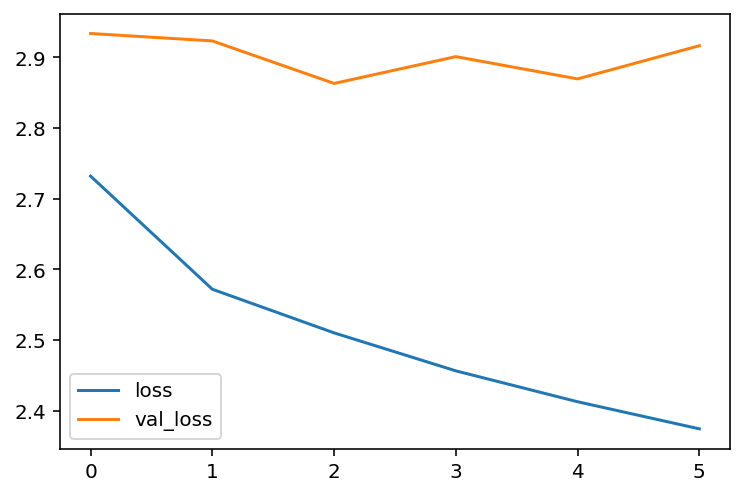

In [17]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [18]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [19]:
self_seq = [
    '49.36.', '', '44.36.', '', '44.38.', '', '44.36.', '38.', '44.36.', '38.', '44.36.', '', '44.38.', '', '44.36.', '38.',
    '44.36.', '', '44.36.', '', '44.38.', '', '44.36.', '38.', '44.36.', '38.', '44.36.', '', '44.38.', '', '44.36.', '38.',
]
generated = [note_dictionary[x] for x in self_seq]

In [20]:
temperature = 0.5
n_generated = 100

att_matrix = np.zeros((n_generated+seq_length, n_generated))

for i in tqdm(range(n_generated)):
    preds = RNN.model.predict(generated[i:])[0]
    generated.append(sample(preds, temperature))
    if use_attention:
        att_preds = RNN.att_model.predict(generated[i:])[0]
        att_matrix[(i-len(att_preds)+seq_length):(i+seq_length), i] = att_preds

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
generated_to_notes = [inv_note_dictionary[i] for i in generated]
generated_to_notes[64:78]

['51.37.',
 '38.',
 '51.37.36.',
 '38.',
 '',
 '',
 '',
 '55.48.',
 '38.',
 '55.48.36.',
 '53.',
 '49.38.',
 '44.33.36.',
 '44.51.45.']

In [22]:
midi_stream = stream.Stream()

for gen_notes in generated_to_notes:
    
    gen_notes = gen_notes.split('.')[:-1]
    # chord
    if len(gen_notes) > 1:
        cur_chord = []
        for cur_note in gen_notes:
            new_note = note.Note(int(cur_note))
            new_note.duration = duration.Duration(type='16th')
            new_note.soredInstrument = instrument.Percussion()
            cur_chord.append(new_note)
        midi_stream.append(chord.Chord(cur_chord))
    elif gen_notes != []:
        if gen_notes[0] == 'del':
            new_note = note.Rest()
            new_note.duration = duration.Duration(type='16th')
            new_note.storedInstrument = instrument.Percussion()
            midi_stream.append(new_note)
        else:
            new_note = note.Note(int(gen_notes[0]))
            new_note.duration = duration.Duration(type='16th')
            new_note.soredInstrument = instrument.Percussion()
            midi_stream.append(new_note)
    else:
        new_note = note.Rest()
        new_note.duration = duration.Duration(type='16th')
        new_note.storedInstrument = instrument.Percussion()
        midi_stream.append(new_note)
        
midi_stream = midi_stream.chordify()

In [23]:
midi_stream.write('midi', fp=os.path.join('output' + '.mid'))

'output.mid'

In [24]:
# if use_attention:
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = ax.imshow(att_matrix[(seq_length-2):,], cmap='coolwarm', interpolation='nearest')
#     ax.set_xticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.set_yticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
#     ax.set_xticks(np.arange(len(generated_to_notes) - seq_length))
#     ax.set_yticks(np.arange(len(generated_to_notes)- seq_length+2))
#     ax.set_xticklabels([n for n in generated_to_notes[(seq_length):]])
#     ax.set_yticklabels([n for n in generated_to_notes[(seq_length - 2):]])
#     ax.xaxis.tick_top()    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
#              rotation_mode="anchor")

#     plt.show()